# Classification: Instant Recognition with Caffe

Adapted from http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

from IPython.display import clear_output # to clear command output when this notebook gets too cluttered

* Load `caffe`.

In [4]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import os
home_dir = os.getenv("HOME")
caffe_root = os.path.join(home_dir, 'caffe')  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, os.path.join(caffe_root, 'python'))

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [5]:
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !~/caffe/scripts/download_model_binary.py ~/caffe/models/bvlc_reference_caffenet

...100%, 232 MB, 526 KB/s, 452 seconds passed

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [6]:
caffe.set_mode_cpu()

model_def = os.path.join(caffe_root, 'models', 'bvlc_reference_caffenet','deploy.prototxt')
model_weights = os.path.join(caffe_root, 'models','bvlc_reference_caffenet','bvlc_reference_caffenet.caffemodel')

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [7]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(os.path.join(caffe_root, 'python','caffe','imagenet','ilsvrc_2012_mean.npy'))
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [8]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

(-0.5, 479.5, 359.5, -0.5)

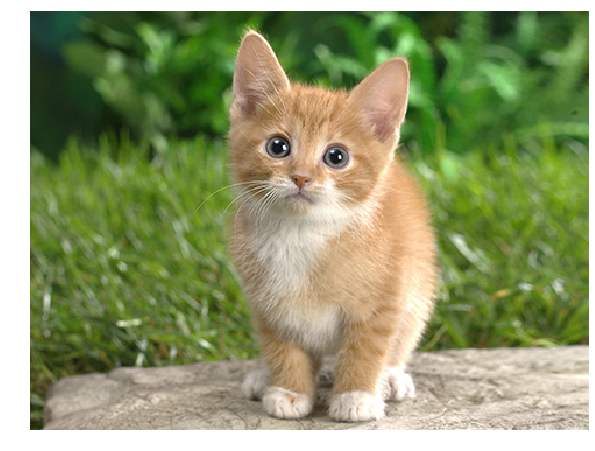

In [9]:
image = caffe.io.load_image(os.path.join(caffe_root, 'examples', 'images','cat.jpg'))
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
plt.axis('off')

* Adorable! Let's classify it!

In [10]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

In [12]:
### perform classification
output = net.forward()
print output

{'prob': array([[  1.19005394e-09,   1.75334808e-05,   2.98291951e-08, ...,
          3.04595993e-09,   1.07184258e-06,   3.69858353e-05],
       [  1.19005394e-09,   1.75334808e-05,   2.98291951e-08, ...,
          3.04595993e-09,   1.07184258e-06,   3.69858353e-05],
       [  1.19005394e-09,   1.75334808e-05,   2.98291951e-08, ...,
          3.04595993e-09,   1.07184258e-06,   3.69858353e-05],
       ..., 
       [  1.19005394e-09,   1.75334808e-05,   2.98291951e-08, ...,
          3.04595993e-09,   1.07184258e-06,   3.69858353e-05],
       [  1.19005550e-09,   1.75335226e-05,   2.98292342e-08, ...,
          3.04596970e-09,   1.07184405e-06,   3.69858135e-05],
       [  1.19005550e-09,   1.75335226e-05,   2.98292342e-08, ...,
          3.04596970e-09,   1.07184405e-06,   3.69858135e-05]], dtype=float32)}


In [13]:
output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [14]:
# load ImageNet labels
labels_file = os.path.join(caffe_root, 'data','ilsvrc12','synset_words.txt')
if not os.path.exists(labels_file):
    !~/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

Downloading...
--2016-08-29 14:14:04--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: 'caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008   401KB/s   in 32s    

2016-08-29 14:14:37 (539 KB/s) - 'caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.


In [15]:
print labels
# clear_output()

['n01440764 tench, Tinca tinca' 'n01443537 goldfish, Carassius auratus'
 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'
 'n01491361 tiger shark, Galeocerdo cuvieri'
 'n01494475 hammerhead, hammerhead shark'
 'n01496331 electric ray, crampfish, numbfish, torpedo'
 'n01498041 stingray' 'n01514668 cock' 'n01514859 hen'
 'n01518878 ostrich, Struthio camelus'
 'n01530575 brambling, Fringilla montifringilla'
 'n01531178 goldfinch, Carduelis carduelis'
 'n01532829 house finch, linnet, Carpodacus mexicanus'
 'n01534433 junco, snowbird'
 'n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea'
 'n01558993 robin, American robin, Turdus migratorius' 'n01560419 bulbul'
 'n01580077 jay' 'n01582220 magpie' 'n01592084 chickadee'
 'n01601694 water ouzel, dipper' 'n01608432 kite'
 'n01614925 bald eagle, American eagle, Haliaeetus leucocephalus'
 'n01616318 vulture'
 'n01622779 great grey owl, great gray owl, Strix nebulosa'
 'n01629819 Eur

In [16]:
print 'output label:', labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

In [17]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31244624, 'n02123045 tabby, tabby cat'),
 (0.23797056, 'n02123159 tiger cat'),
 (0.12387878, 'n02124075 Egyptian cat'),
 (0.10075183, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957229, 'n02127052 lynx, catamount')]

* We see that less confident predictions are sensible.

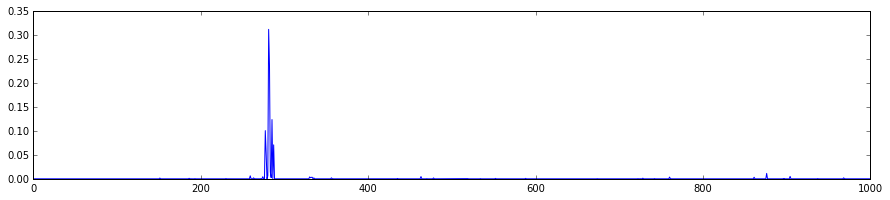

In [18]:
# Plotting probabilities
plt.figure(figsize=(15, 3))
plt.plot(output_prob)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode: http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb

### 6. Wrapping up the prediction code into a function

In [27]:
def predict_imageNet(image_filename):
    image = caffe.io.load_image(image_filename)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)

    # perform classification
    net.forward()

    # obtain the output probabilities
    output_prob = net.blobs['prob'].data[0]

    # sort top five predictions from softmax output
    top_inds = output_prob.argsort()[::-1][:5]

    plt.imshow(image)
    plt.axis('off')

    print 'probabilities and labels:'
    predictions = zip(output_prob[top_inds], labels[top_inds])

    plt.figure(figsize=(15, 3))
    plt.plot(output_prob)
    return predictions

#### 6.1 Try an image from the webcam

In [19]:
!cheese
clear_output()

In [20]:
new_image_dir = os.path.join(home_dir,'Pictures', 'Webcam')
new_images = os.listdir(new_image_dir)
print new_images

['2016-08-29-144401.jpg', '2016-01-31-014809.jpg']


In [21]:
predict_imageNet(os.path.join(new_image_dir, new_images[-1]))

NameError: name 'predict_imageNet' is not defined

#### 6.2 Try an image from the Internet

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

In [22]:
# download an image
my_image_url = "..."  # paste your URL here
# for example:
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

--2016-08-29 14:55:34--  https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443340 (1.4M) [image/jpeg]
Saving to: 'image.jpg’

100%[======================================>] 1,443,340    775KB/s   in 1.8s   

2016-08-29 14:55:38 (775 KB/s) - 'image.jpg’ saved [1443340/1443340]



probabilities and labels:


[(0.96841651, 'n02480495 orangutan, orang, orangutang, Pongo pygmaeus'),
 (0.030277379, 'n02492660 howler monkey, howler'),
 (0.00084077677, 'n02493509 titi, titi monkey'),
 (0.00014605188, 'n02493793 spider monkey, Ateles geoffroyi'),
 (7.3880023e-05, 'n02488291 langur')]

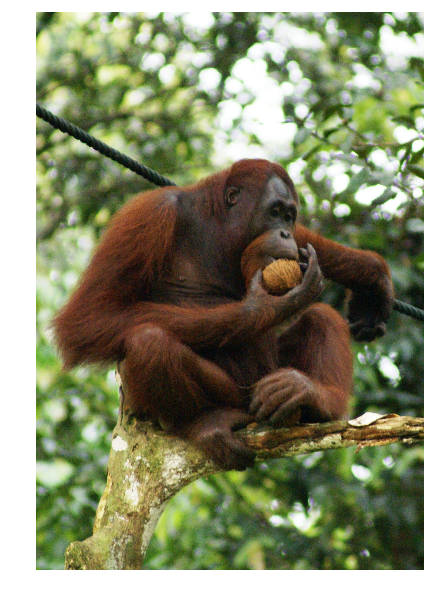

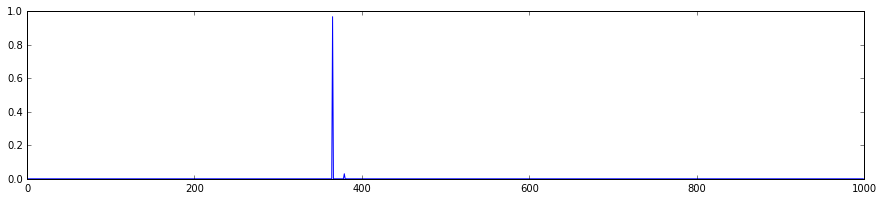

In [26]:
# transform it and copy it into the net
predict_imageNet('image.jpg')